## Introduction to Bayesian Power Analysis: Exclude a Null Value


Recently, I have been thinking a lot about data-driven decision-making, particularly in the context of experimentation. Why? I am uncomfortable (at all!) with the common practice of using p-values and frequentist null hypothesis significance testing to make decisions. I don't feel confident about the approach. I think it is because I do not get it. For instance, when I am forced to explain the definition of a confidence interval precisely, it does not come naturally. I always need to check with a trustworthy source (it is common to find wrong explanations online). If I do not understand it, I can not use it, especially for decision-making. I always play this exercise when thinking about business recommendations in real applications: "Would I bet my salary on this?" Whenever I work with p-values, the answer to this question is no.

There must be a better way! Of course, I am a Bayesian, but I did not want this to be a bias to try to find an answer. Frequentist hypothesis testing is so popular that there should be a reason for it. Hence, I started learning more about the topic. I started with the classic ["Statistical Decision Theory and Bayesian Analysis"](https://link.springer.com/book/10.1007/978-1-4757-4286-2) by James O. Berger. What a fantastic book! It is expensive, but it is worth every penny. The book presents solid foundations on decision theory for both frequentist and Bayesian viewpoints and aims to be agnostic about these two paradigms. Nevertheless, based on clear explanations and examples, the author can not prevent suggesting that the Bayesian approach is better for decision-making processes. I am not here to repeat the arguments, but I felt very much identified with the narrative and arguments, so I was (re-) convinced of following the Bayesian path as the framework for decision theory in practice. Of course, this was not surprising, given my Bayesian background. But I want to emphasize my intention to step back and avoid getting trapped in fanatism. 

Warning: I am not saying Bayesian methods solve everything and that frequentist methods are wrong! No, this is a much more personal statement that represents the way I think about decision-making and uncertainty. If one is not careful, Bayesian methods can fail badly. See, for example, [Is Bayesian A/B Testing Immune to Peeking? Not Exactly](http://varianceexplained.org/r/bayesian-ab-testing/) by David Robinson. With big power comes big responsibility.

Having accepted this, I immediately thought about a significant challenge. How to use Bayesian methods in organizations where frequentist approaches, p-values, and confidence intervals are the bread and butter? Trying to teach Bayesian methods in the industry is hard because of the steep learning curve and the fact that most folks out there do not see the point ("let me and my p-value do our thing"). This is not an easy problem. Ultimately, I want to use my skills to provide business value through honest decision-making; I want to bet my salary on all recommendations I give. Hence, I decided I am trying to write, for me and the community, more accessible examples about Bayesian decision theory (it is mainly for me). I am not saying there is no great material available (there is! I will mention some references below). I simply want to have something written by myself when discussing this subject with others. I had already started (unconsciously) with the simulation example ["Prior Predictive Modeling in Bayesian AB Testing"](https://juanitorduz.github.io/prior_predictive_ab_testing/) replicating the great blog ["The Bet Test: Spotting Problems in Bayesian A/B Test Analysis"](https://www.geteppo.com/blog/the-bet-test-problems-in-bayesian-ab-test-analysis) by [Tyler Buffington](https://www.geteppo.com/author/tyler-buffington) from [Eppo](https://www.geteppo.com/). They have excellent content; see, for example, ["Bayes Vs. Frequentism Can Be a Big Deal"](https://www.geteppo.com/blog/bayes-vs-frequentism-can-be-a-big-deal) by [Demetri Pananos](https://dpananos.github.io/).

I feel pretty confident about prior-predictive modeling (see, for example, ["Prior Predictive Modeling"](https://www.pymc-marketing.io/en/stable/notebooks/general/prior_predictive.html) from the [PyMC-Marketing](https://www.pymc-marketing.io/en/stable/index.html) example gallery). On the other hand, when it comes to experimentation, I have two clear gaps: Bayesian power analysis and early stopping. These are the topics I want to learn more about. In this post, we will start with the core ideas behind Bayesian power analysis. There are many great resources on this topic, such as Chapter 16 of ["Regression and Other Stories"](https://avehtari.github.io/ROS-Examples/). One reference that particular caught my mind is the paper ["The Bayesian New Statistics: Hypothesis testing, estimation, meta-analysis, and power analysis from a Bayesian perspective"](https://link.springer.com/content/pdf/10.3758/s13423-016-1221-4.pdf) by  John K. Kruschke and Torrin M. Liddell. Please read this paper (really, do it!). It is a fantastic paper describing the details and nuances of frequentist and Bayesian hypothesis testing. You can find lecture videos [here](https://doingbayesiandataanalysis.blogspot.com/2013/11/optional-stopping-in-data-collection-p.html). Similarly as before, the authors can not stop themselves from recommending Bayesian inference for decision-making. Again, I do not want to go into the arguments since these can not be better explained than in the paper.
Nevertheless, I want to highlight a remarkable fact from the manuscript: one of the recent principles by the American Statistical Association states that "Scientific conclusions and business or policy decisions should not be based only on whether a p-value passes a specific threshold. ... The widespread use of 'statistical significance' (generally interpreted as 'p < 0.05') as a license for making a claim of a scientific finding (or implied truth) leads to considerable distortion of the scientific process." Hence, I am (we!) are not alone.

Let's come back to Bayesian power analysis testing. The paper above presents a very transparent way of performing power analysis in a way I can relate and link to my previous read on decision theory. An extended and detailed description of the approach is presented in Chapter 13 of the book ["Doing Bayesian Data Analysis"](https://nyu-cdsc.github.io/learningr/assets/kruschke_bayesian_in_R.pdf) by John K. Kruschke. In this blog post, we focus on the first and simplest example presented in the book: do a power analysis for a coin-flip example when our goal is to exclude a null value. Note how the power analysis is tight to a "goal". Thus, we can have many goals like "affirm a predicted value of a parameter" or "achieve precision in the estimate of a parameter". We aim to provide complementary material to the chapter's content and reproduce the results from Table 13.1. in PyMC. We will do this following the schematic logic of Figure 13.1

**Steps:**

1. From the hypothetical distribution of parameter values, randomly generate representative values.
2. From the representative parameter values, generate a random sample of data, using the planned sampling method. 
3. From the simulated sample of data, compute the posterior estimate, using Bayesian analysis with audience-appropriate priors.
4. From the posterior estimate, tally whether or not the goals were attained.
5. Repeat the above steps many times, to approximate the power.

We will describe each step in detail in the context of the coin-flip example.

The hope is to provide foundations to work out more complex examples in the future.

Remark: There are many ways to do Bayesian power analysis. See, for example, the approach in Max Kochurov's video [5: Bayesian AB Testing (State of Bayes Lecture Series)](https://www.youtube.com/watch?v=QllfKQH-yQ4).

## Prepare Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import numpy.typing as npt
import pandas as pd
import preliz as pz
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
seed: int = sum(map(ord, "power_sample_size"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Description of the Strategy

We strongly recommend reading the original part of the example from the book before continuing (Section 13.2.1). Still, we provide the main ideas below.

Let us assume we have a coin. The **goal** is to show that the coin is unfair. In other words, we want to show that the $95\%$ HDI (Highest Density Interval) excludes a ROPE (Region of Practical Equivalence) around $\theta = 0.50$. To do so, we follow the steps below:

**Step 1.** Establish the hypothetical distribution of parameter values from which we will generate simulated data. In the example from the book, the hypothetical distribution is a beta distribution with shape parameters of $0.65 \cdot (2000 - 2) + 1$ and $(1 - 0.65) \cdot (2000 - 2) + 1$. The value of $2000$ is arbitrary; it’s as if the generating mean of $0.65$ was based on fictitious previous data containing $2000$ flips.

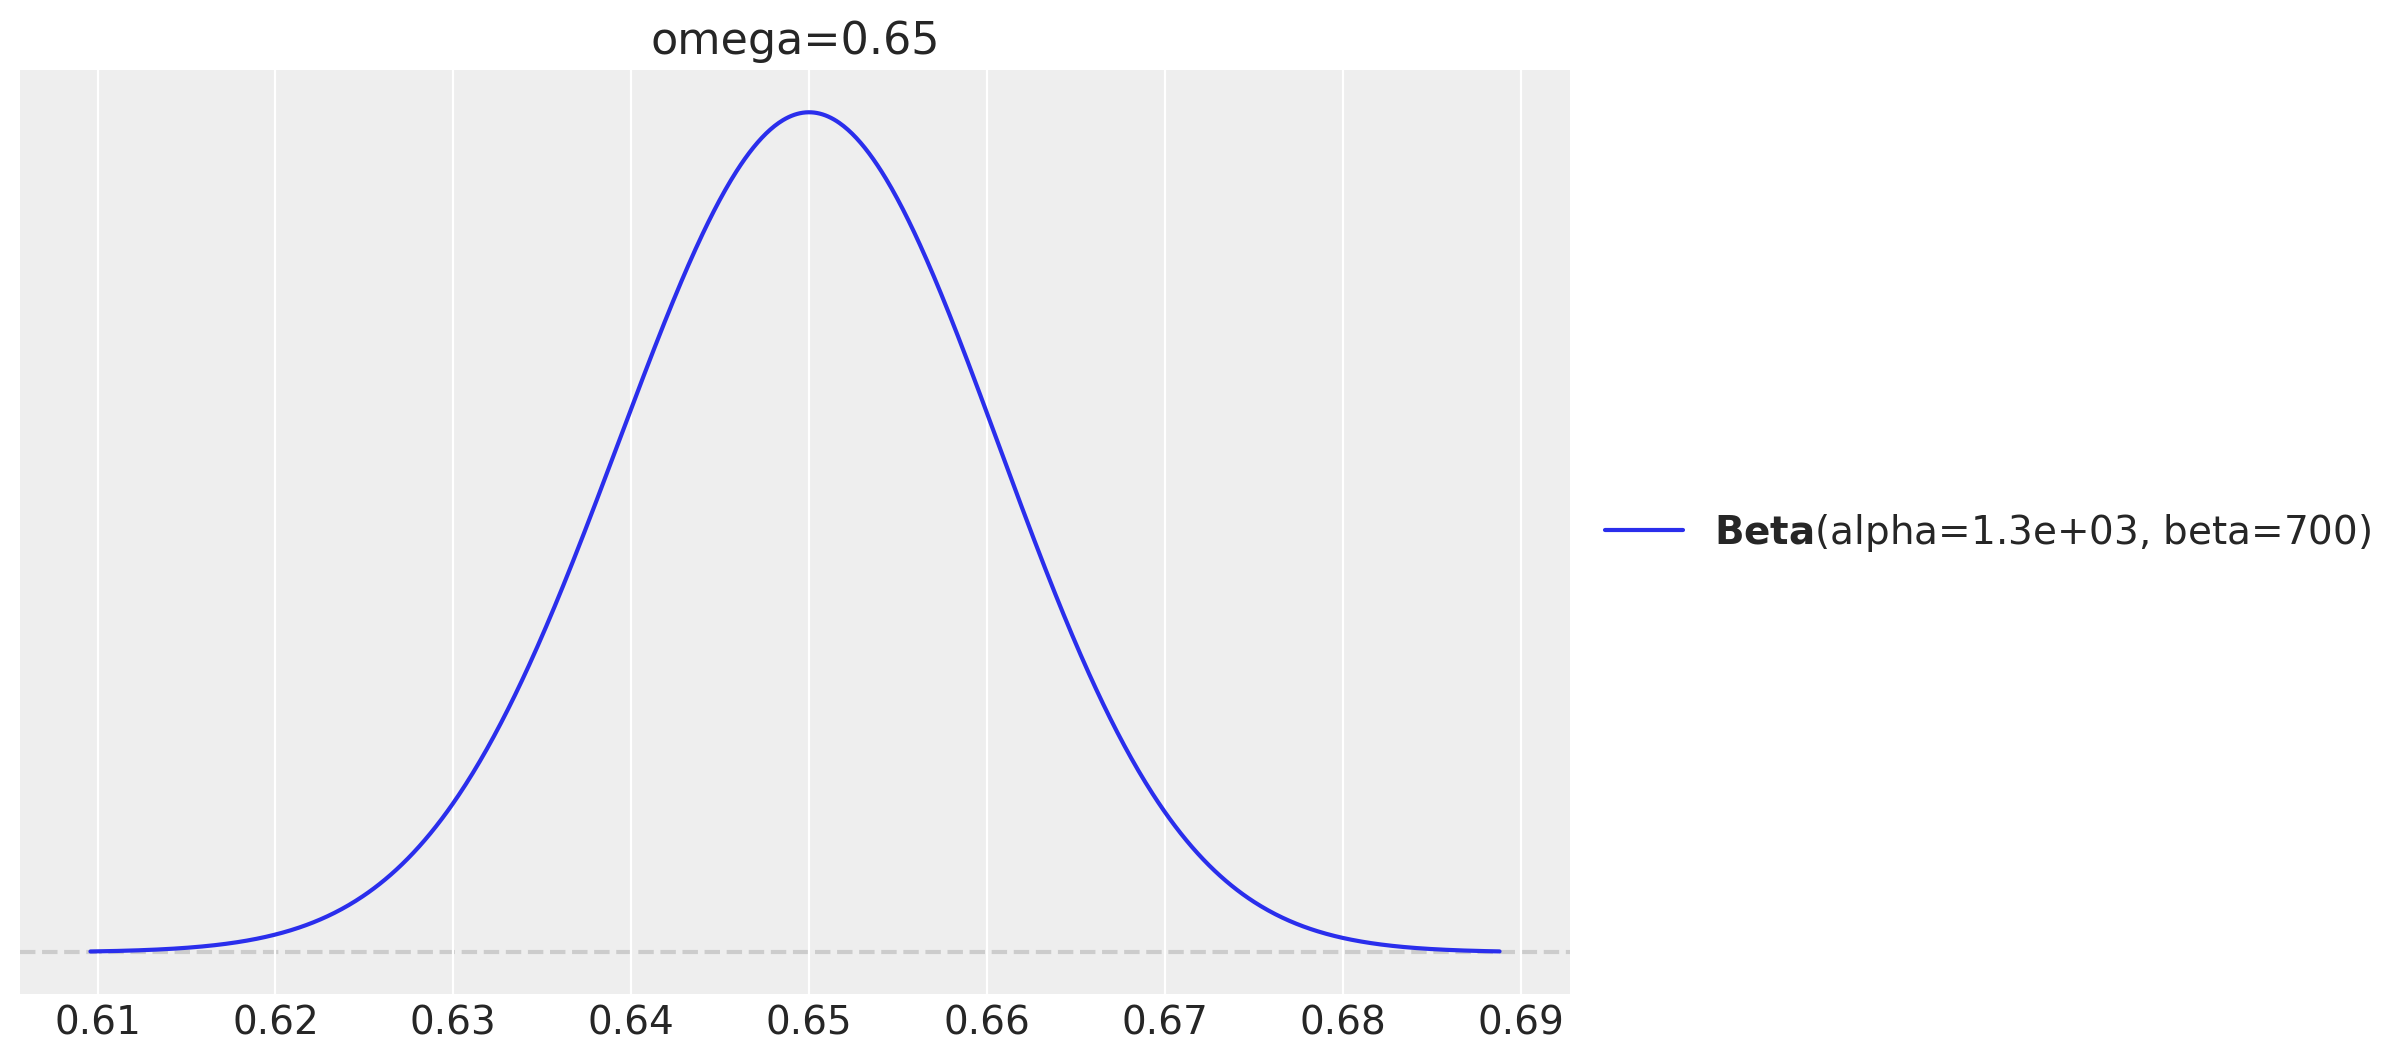

In [18]:
fig, ax = plt.subplots()
omega = 0.65
pz.Beta(alpha=omega * (2_000 - 2) + 1, beta=(1 - omega) * (2_000 - 2) + 1).plot_pdf(
    ax=ax
)
ax.set(title=f"omega={omega}");

In practice, we can use many different distributions. For that purpose we store various distribution means in the variable `omegas`.

In [19]:
omegas = np.linspace(0.5, 0.85, 8)
print(f"omegas: {omegas}")

omegas: [0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85]


**Step 2:** We generate random samples of data from the hypothetical distribution and use it to generate synthetic data, i.e. flip coin results. For example, from the hypothetical distribution that is centered on $\theta = 0.65$, suppose that the selected value is $0.638$. We can use this value to simulate flipping a coin with that bias $N$ times. This value of $N$ is the sample size we want to study.

Let's generate some sample sizes to consider.

In [21]:
sample_sizes = np.linspace(10, 450, 23, dtype=int)
print(f"sample_sizes: {sample_sizes}")

sample_sizes: [ 10  30  50  70  90 110 130 150 170 190 210 230 250 270 290 310 330 350
 370 390 410 430 450]


**Step 3:** We fit the model we plan to use in practice (with the audience-appropriate priors) to the simulated data above. This will provide us with the posterior distribution of the parameter $p\in[0,1$ we are interested in.


**Step 4:** Tally (assess) whether or not the $95\%$ HDI excludes a ROPE around the null value of $\theta = 0.50$. We choose the ROPE to be $[0.48, 0.52]$.

**Step 5:** Repeat the above steps many times, to approximate the power of the experiment.

We specify the number of simulations to run in the variable `n_simulations`.

In [26]:
n_simulations = 500


Now that we have clarified the steps, let's implement the logic in PyMC.


## Generate Random Samples of Data

The first step is to generate random samples of data from the hypothetical distribution. We do this by sampling from the beta distribution with the shape parameters we defined earlier. 

**Remark:** Observe that we can *vectorize* the whole simulation process. Hence, we do not need to loop over any of the parameters.

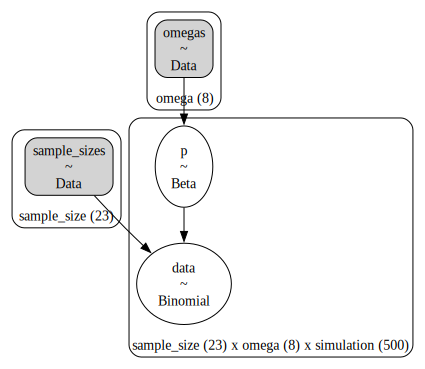

In [5]:
with pm.Model(
    coords={
        "sample_size": sample_sizes,
        "omega": omegas,
        "simulation": range(n_simulations),
    }
) as data_generating_model:
    # Data container for the sample sizes we want to consider.
    sample_sizes_ = pm.Data(
        "sample_sizes",
        sample_sizes,
        dims=("sample_size",),
    )
    # Expand the sample sizes to the shape of the model.
    sample_sizes_expanded = pt.expand_dims(
        pt.as_tensor_variable(sample_sizes_), axis=[1, 2]
    )
    # Data container for the omegas we want to consider.
    omegas_ = pm.Data("omegas", omegas, dims=("omega",))
    # Expand the omegas to the shape of the model.
    omegas_expanded = pt.expand_dims(pt.as_tensor_variable(omegas_), axis=[0, 2])
    # Sample from the hypothetical distribution.
    p = pm.Beta(
        "p",
        alpha=omegas_expanded * (2_000 - 2) + 1,
        beta=(1 - omegas_expanded) * (2_000 - 2) + 1,
        dims=("sample_size", "omega", "simulation"),
    )
    # Generate the data from the binomial distribution.
    pm.Binomial(
        "data",
        n=sample_sizes_expanded,
        p=p,
        dims=("sample_size", "omega", "simulation"),
    )

pm.model_to_graphviz(data_generating_model)


Now we can simply do a forward pass to generate the data.

In [6]:
with data_generating_model:
    generating_model_idata = pm.sample_prior_predictive(samples=1, random_seed=rng)

generated_data = generating_model_idata["prior"]["data"].sel(chain=0, draw=0).to_numpy()

# Verify the shape of the generated data.
assert generated_data.shape == (len(sample_sizes), len(omegas), n_simulations)

Sampling: [data, p]


## Compute Posterior Estimates

Now we fit the model to the generated data. We specify a mild-informative prior distribution for the parameter $p$ centered on $0.5$ with a standard deviation of $0.1$.

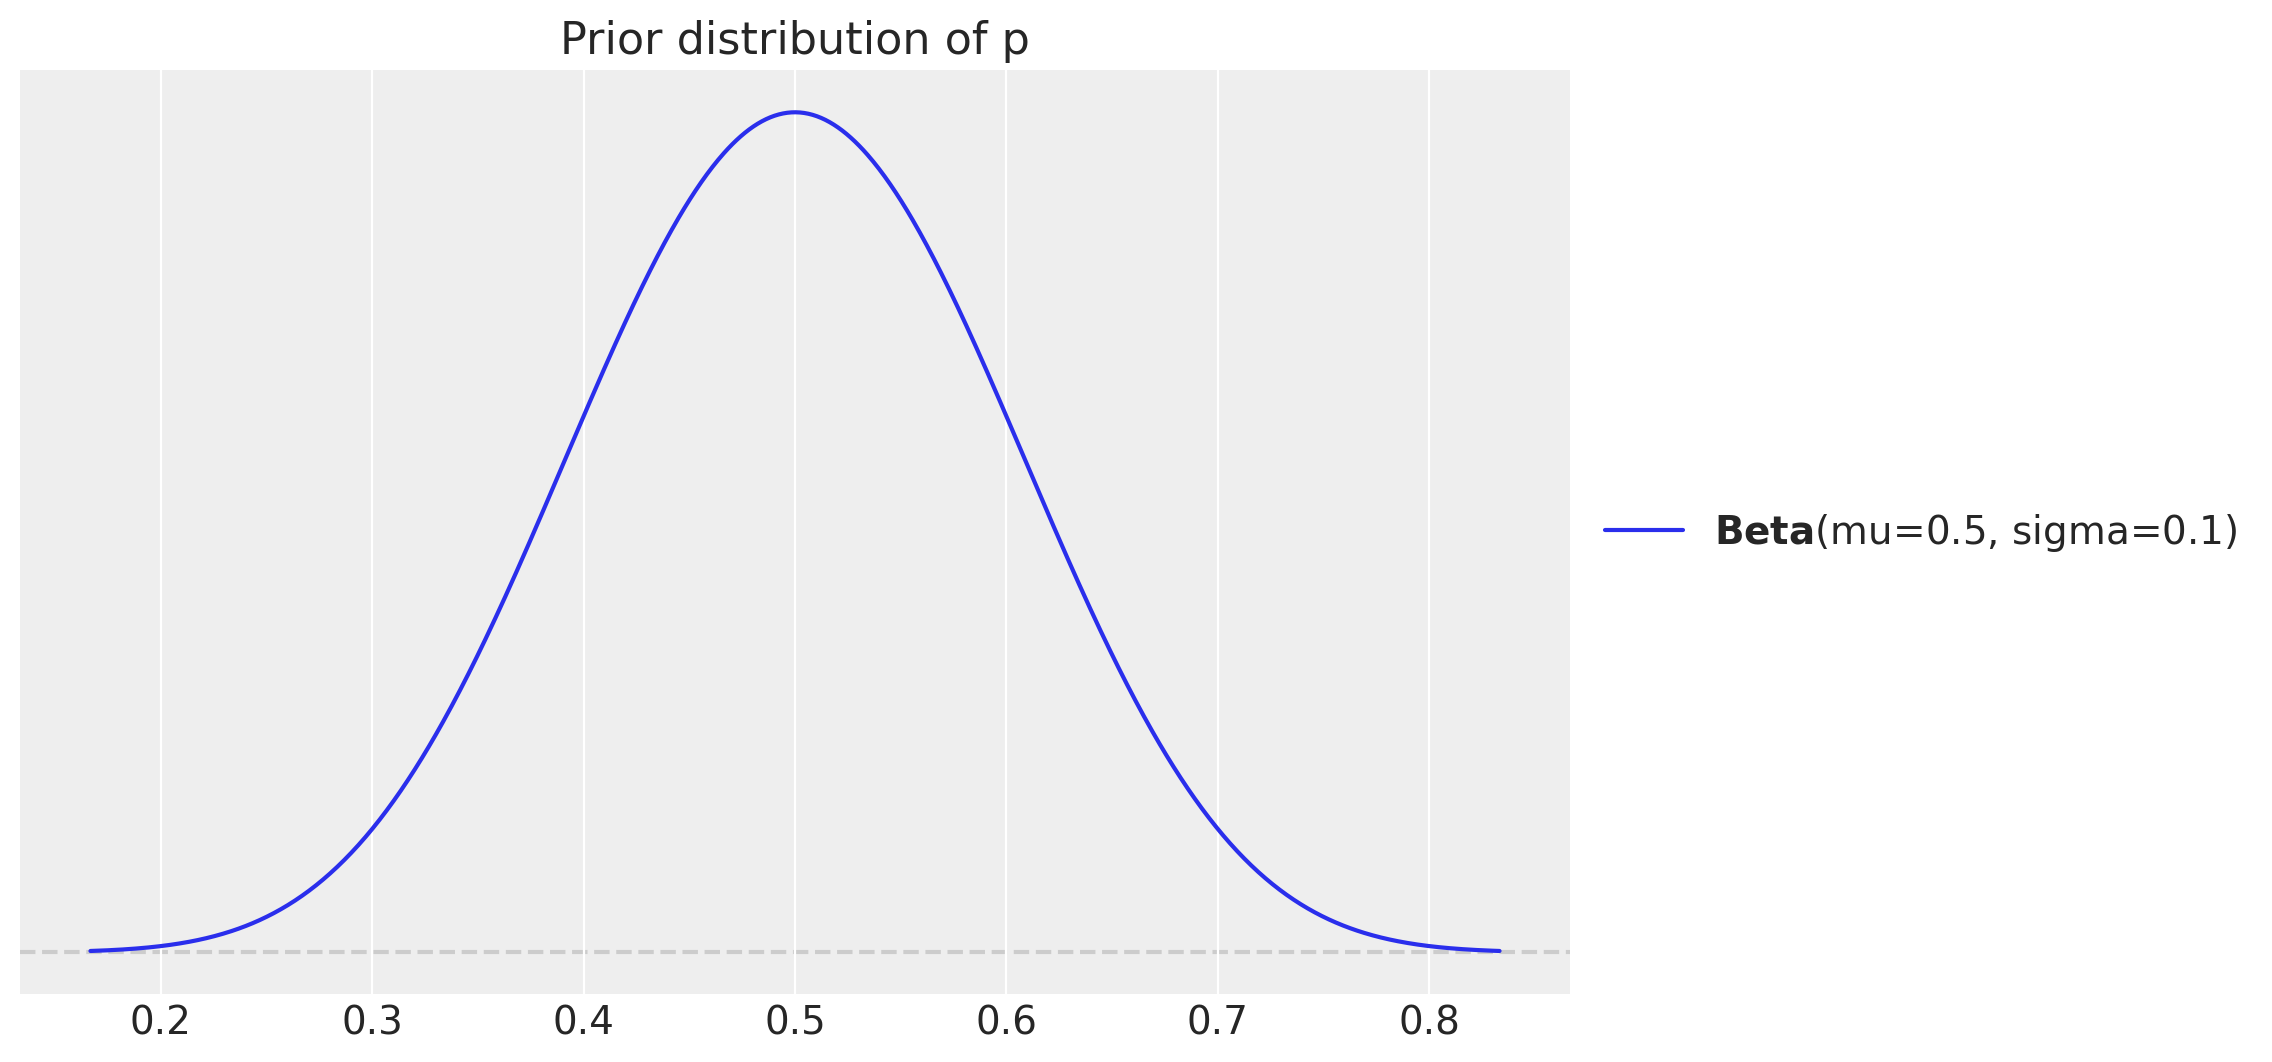

In [7]:
fig, ax = plt.subplots()
pz.Beta(mu=0.5, sigma=0.1).plot_pdf(ax=ax)
ax.set(title="Prior distribution of p");

Let's write the vectorized model.

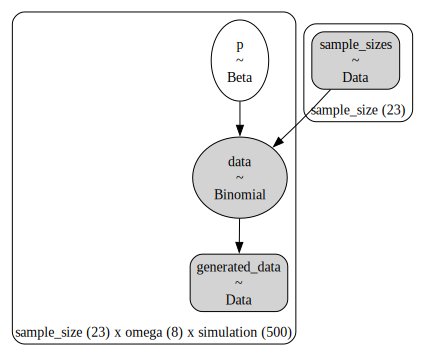

In [8]:
with pm.Model(
    coords={
        "sample_size": sample_sizes,
        "omega": omegas,
        "simulation": range(n_simulations),
    }
) as model:
    # Data container for the generated data from the previous step.
    generated_data_ = pm.Data(
        "generated_data",
        generated_data,
        dims=("sample_size", "omega", "simulation"),
    )
    # Data container for the sample sizes we want to consider.
    # We keep them as as above as we want to vectorize the process.
    sample_sizes_ = pm.Data(
        "sample_sizes",
        sample_sizes,
        dims=("sample_size",),
    )
    # Expand the sample sizes to the shape of the model.
    sample_sizes_expanded = pt.expand_dims(
        pt.as_tensor_variable(sample_sizes_), axis=[1, 2]
    )
    # Specify the prior distribution for the parameter $p$.
    p = pm.Beta(
        "p",
        alpha=0.5,
        beta=0.1,
        dims=("sample_size", "omega", "simulation"),
    )
    # Condition the likelihood on the generated data.
    pm.Binomial(
        "data",
        n=sample_sizes_expanded,
        p=p,
        observed=generated_data_,
        dims=("sample_size", "omega", "simulation"),
    )

pm.model_to_graphviz(model)

Next, we run our NUTS sampler.

In [9]:
%%time

with model:
    idata = pm.sample(
        draws=1_000,
        chains=4,
        nuts_sampler="numpyro",
        random_seed=rng,
    )

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


CPU times: user 1h 35min 3s, sys: 20min 18s, total: 1h 55min 21s
Wall time: 17min 37s


We verify we have no divergences.

In [10]:
print(f"Diverging: {idata['sample_stats']['diverging'].sum().item()}")

Diverging: 0


Let's consider the posterior distribution summary for the specific values of the simulation `omega=0.65` and `sample_size=150` (which is the particular case from the book).

In [11]:
az.summary(
    idata["posterior"].sel(sample_size=150, omega=0.65, simulation=slice(None, 10)),
    var_names=["p"],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p[0],0.574,0.040,0.497,0.648,0.0,0.001,7706.0,2839.0,1.0
p[1],0.667,0.038,0.599,0.742,0.0,0.001,6939.0,2920.0,1.0
p[2],0.561,0.040,0.489,0.640,0.0,0.001,7329.0,2892.0,1.0
p[3],0.614,0.039,0.541,0.692,0.0,0.001,6659.0,2783.0,1.0
p[4],0.694,0.037,0.616,0.756,0.0,0.001,7756.0,2283.0,1.0
p[5],0.654,0.039,0.586,0.729,0.0,0.001,7529.0,2581.0,1.0
p[6],0.660,0.039,0.589,0.732,0.0,0.001,6683.0,2264.0,1.0
p[7],0.641,0.038,0.567,0.710,0.0,0.001,7218.0,2868.0,1.0
p[8],0.667,0.039,0.597,0.742,0.0,0.001,7511.0,2719.0,1.0
p[9],0.733,0.035,0.669,0.802,0.0,0.001,7168.0,3172.0,1.0


The r-hat values are close to 1, indicating good convergence.

## Compute How Many Times the Goal is Attained

Now that we have all the posterior samples at hand, we can easily compute our condition of interest. Namely, we want to know how many times the $95\%$ HDI excludes the ROPE. Before doing so, let's visualize the posterior distribution of $p$ for the particular case of `omega=0.65` and `sample_size=150` for the first $100$ simulations.

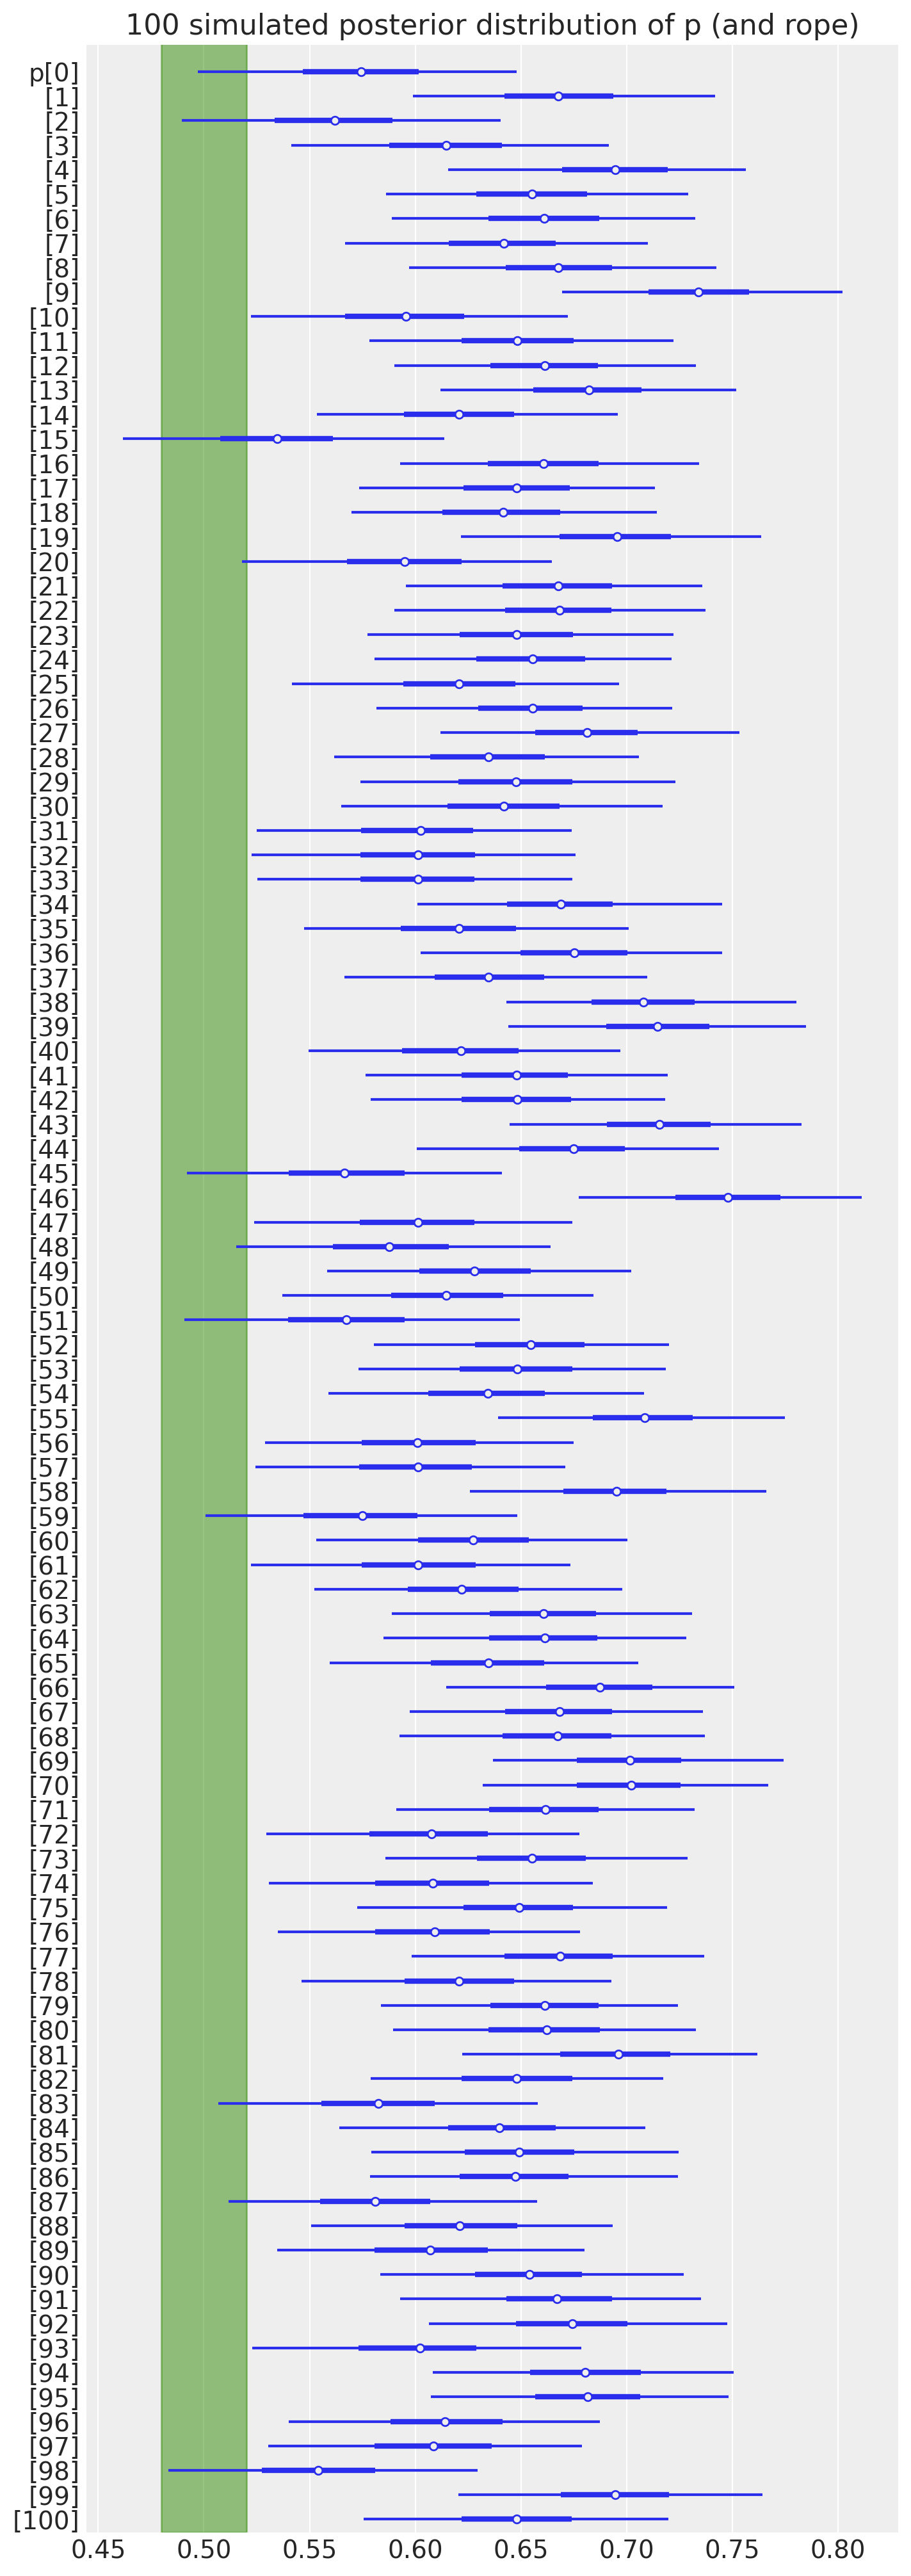

In [12]:
ax, *_ = az.plot_forest(
    idata["posterior"].sel(sample_size=150, omega=0.65, simulation=slice(None, 100)),
    var_names=["p"],
    combined=True,
    rope=[0.48, 0.52],
    figsize=(7, 20),
)

ax.set(title="100 simulated posterior distribution of p (and rope)");

Computing the $95\%$ HDI for the parameter $p$ and evaluating whether it excludes the ROPE is straightforward.

In [22]:
hdi = az.hdi(idata["posterior"], hdi_prob=0.95)["p"]

rope = (0.48, 0.52)

results = ((hdi.sel(hdi="lower") > rope[1]) | (hdi.sel(hdi="higher") < rope[0])).mean(
    dim="simulation"
)

Again, let's compare the power estimation for the particular case of `omega=0.65` and `sample_size=150`.

In [23]:
results.sel(sample_size=150, omega=0.65).item()

0.898

This is the same result as in the book (well, it is $.9$, but it is close).

## Visualize Results

We can now generate the whole Table 13.1 from the book.

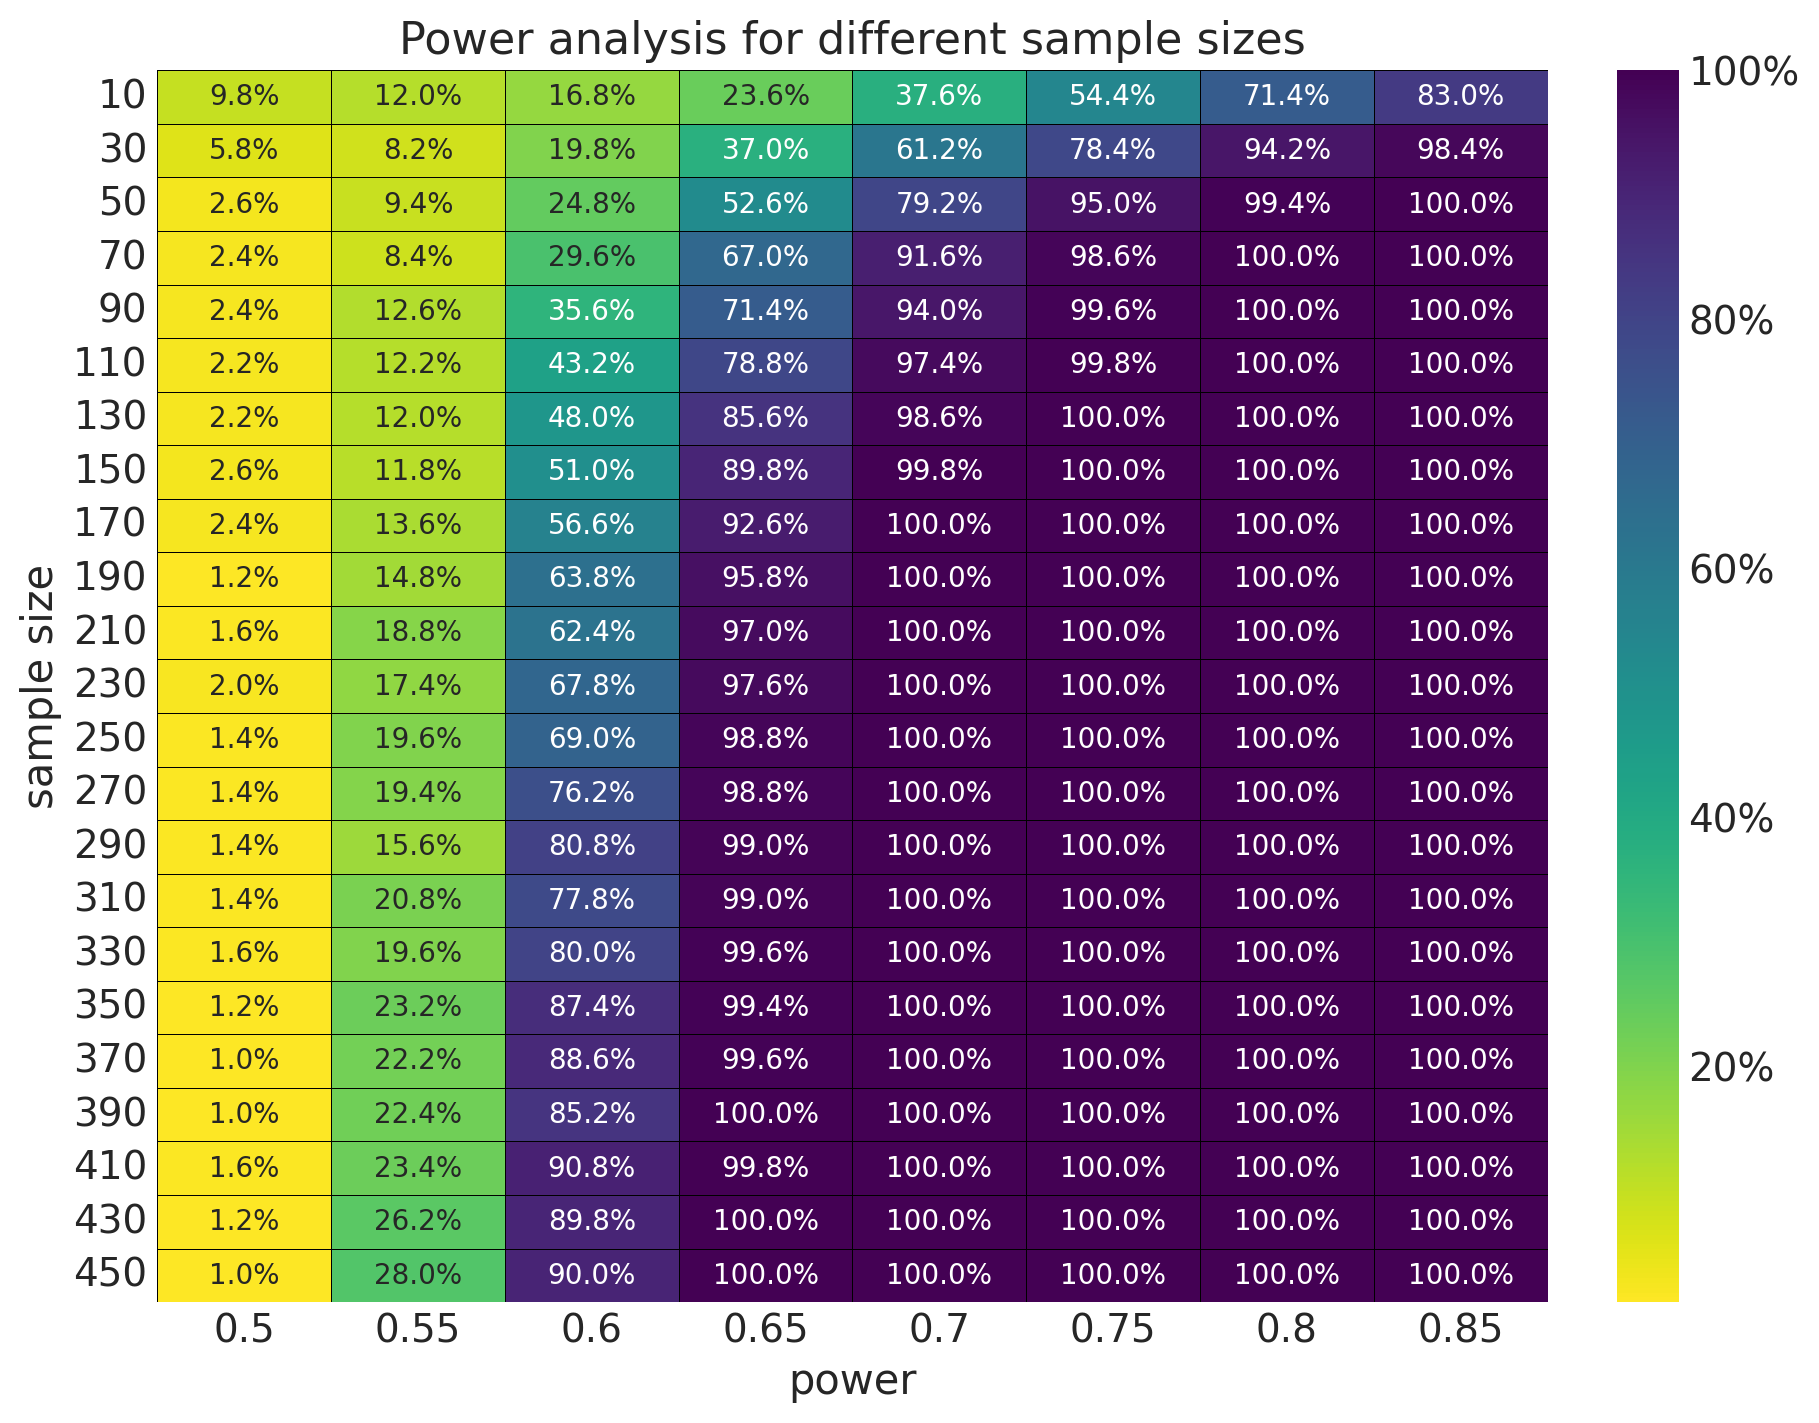

In [24]:
fig, ax = plt.subplots(figsize=(9, 7))

sns.heatmap(
    data=(
        results.to_dataframe()
        .reset_index()
        .pivot_table(index="sample_size", columns="omega", values="p")
    ),
    annot=True,
    cmap="viridis_r",
    linewidths=0.2,
    linecolor="black",
    fmt=".1%",
    cbar_kws={"format": mtick.PercentFormatter(xmax=1)},
    ax=ax,
)
ax.tick_params("y", rotation=0)
ax.set(
    title="Power analysis for different sample sizes",
    xlabel="power",
    ylabel="sample size",
);

The results are very similar to the expected ones.

**Remark:** In the book, all of these results are computed analytically as the math is not too complex. However, in real applications, we need to use simulation methods.

Finally, let's visualize the power curve for different sample sizes.

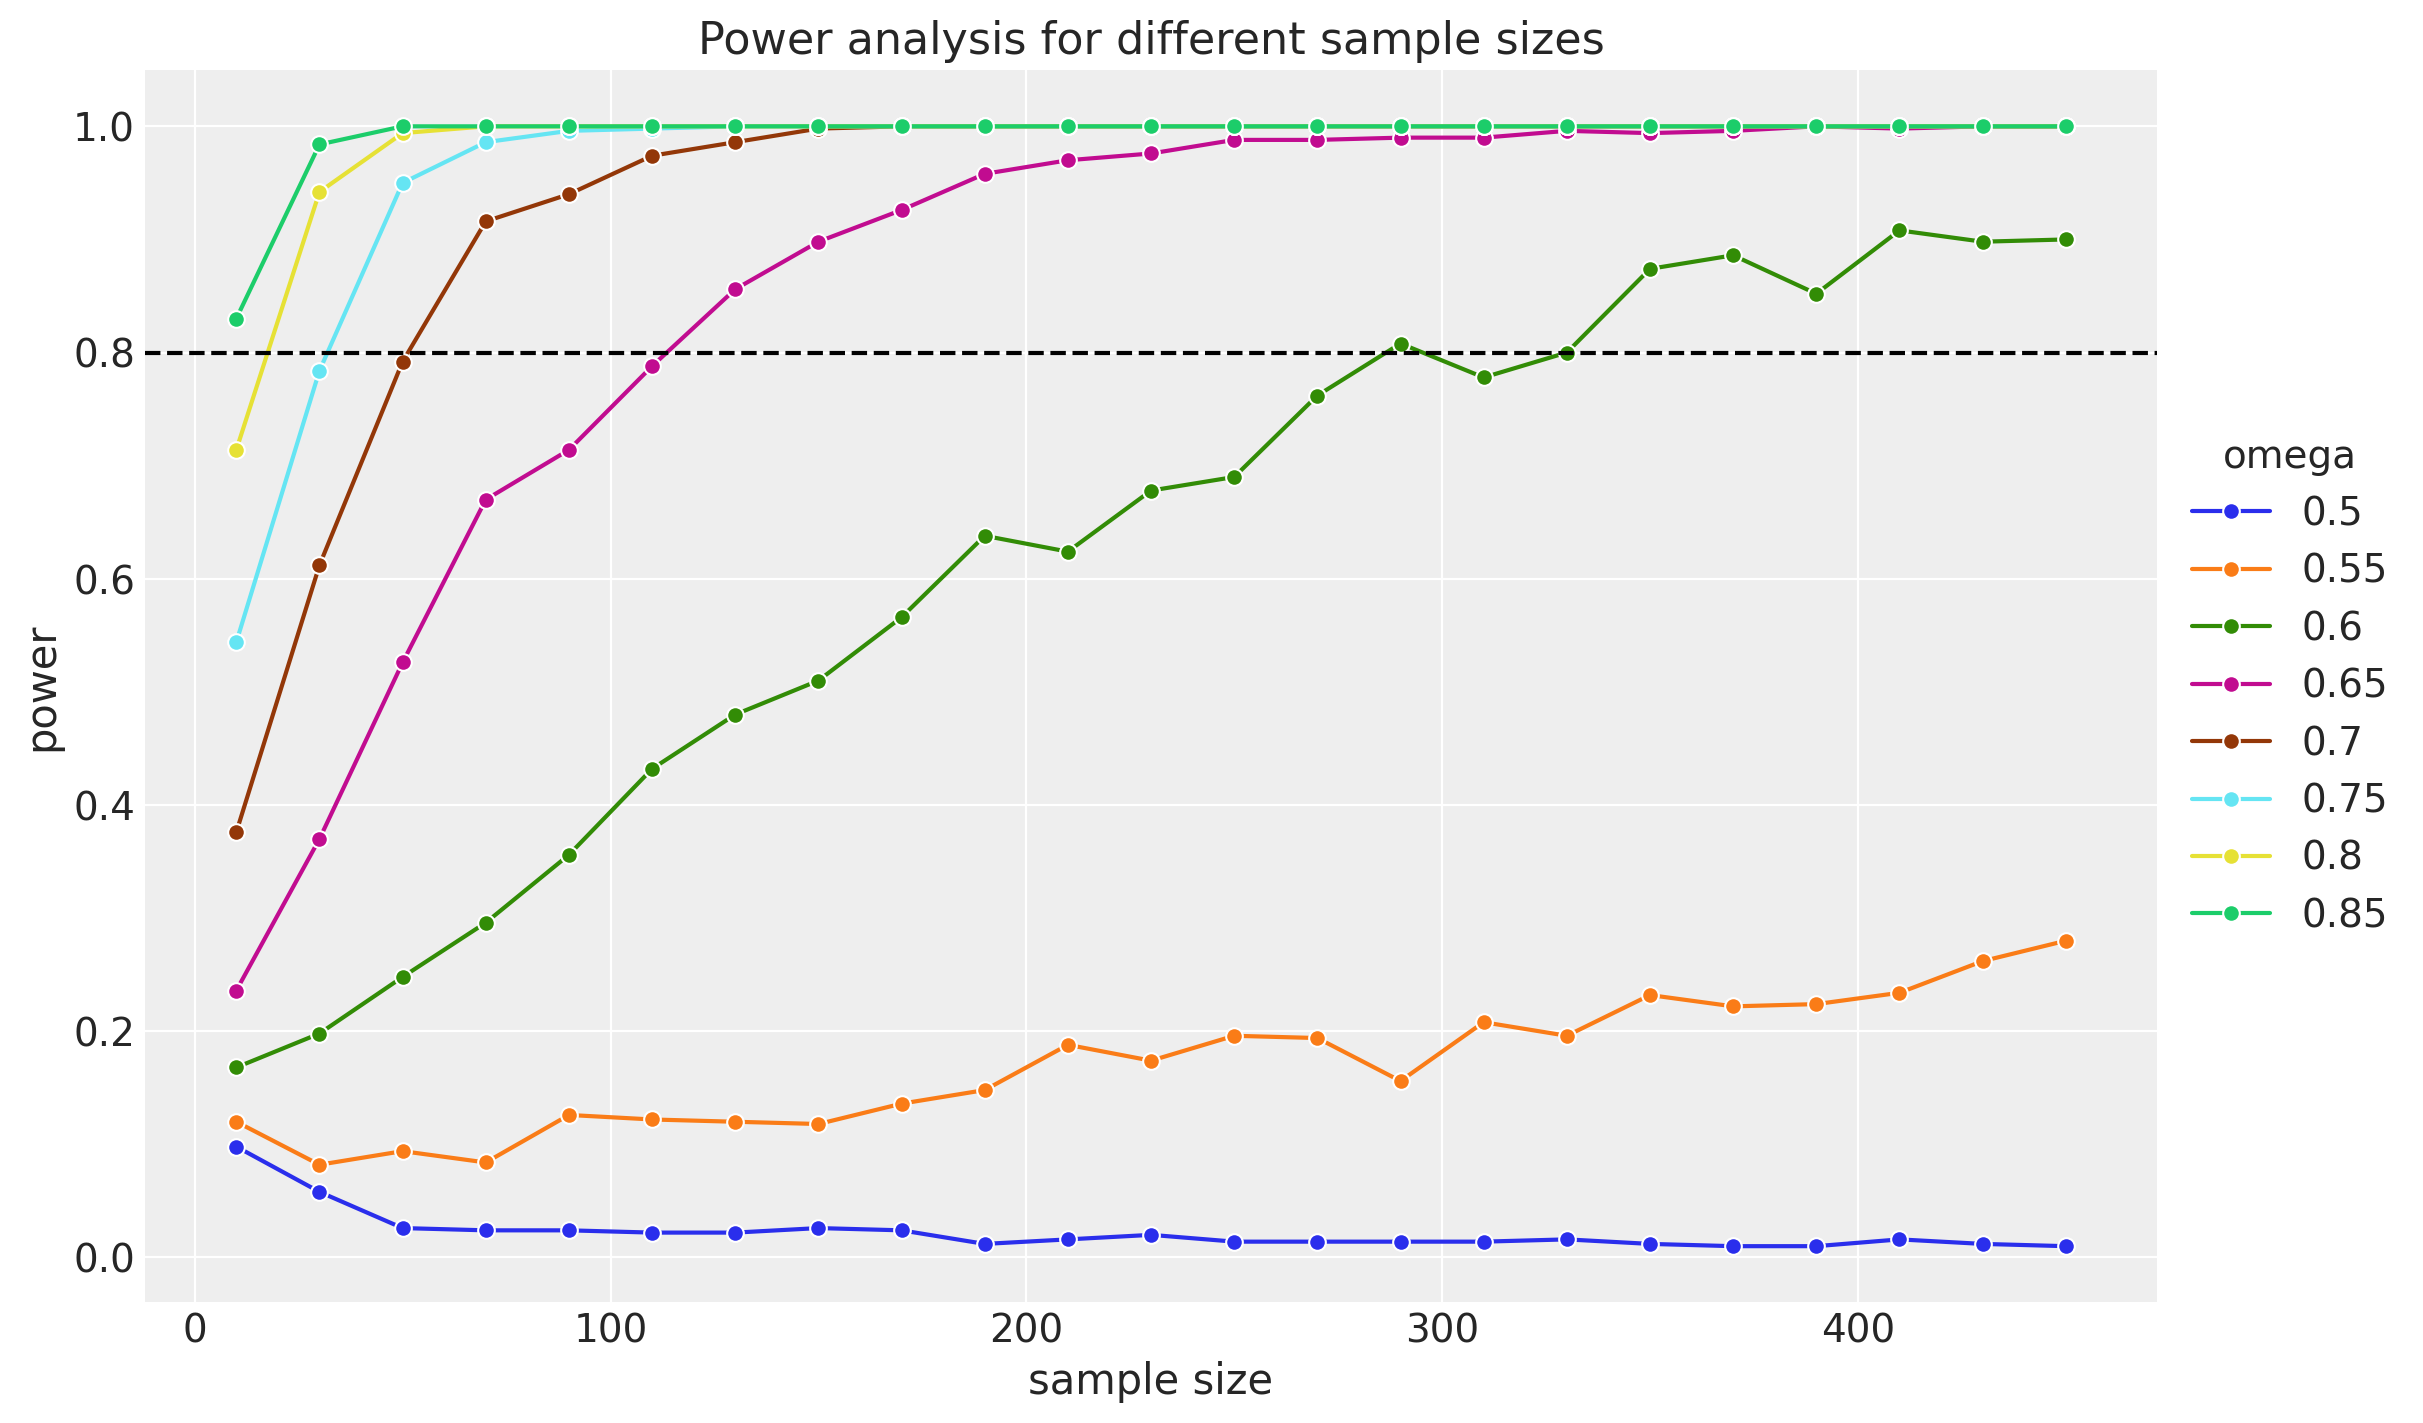

In [35]:
fig, ax = plt.subplots(figsize=(12, 7))

sns.lineplot(
    data=(
        results.to_dataframe()
        .reset_index()
        .assign(omega=lambda x: x["omega"].astype("str"))
    ),
    x="sample_size",
    y="p",
    hue="omega",
    marker="o",
)

ax.axhline(0.8, c="black", ls="--")
ax.legend(loc="center left", title="omega", title_fontsize=14, bbox_to_anchor=(1, 0.5))
ax.set(
    title="Power analysis for different sample sizes",
    xlabel="sample size",
    ylabel="power",
);

Here are some clear remarks about the results from the book:

> - *As generating mode increases (the omegas), the required sample size decreases. This makes sense intuitively: When the generating mode is large, the sample proportion of heads will tend to be large, and so the HDI will tend to fall toward the high end of the parameter domain. In other words, when the generating mode is large, it doesn’t take a lot of data for the HDI to fall consistently above $\theta = 0.5$.*
>
> - *On the other hand, when the generating mode is only slightly above $\theta = 0.5$, then it takes a large sample for the sample proportion of heads to be consistently above $0.5$, and for the HDI to be consistently entirely above $0.5$ (and the ROPE).*

Reproducing and coding this vectorized version of the power analysis example was very interesting. This example provides a solid illustration of the power analysis flow, which I plan to extend for more complex applications.